In [1]:
from autoencoder import Autoencoder
from SINDY import sindy_library_tf
from HIFF import generate_training_sat
import matplotlib.pyplot as plt
from typing import List, Optional


In [2]:
epochs = 5 
batch_size = 16
# generate the trainig set 
print("[INFO] generating trainnig dataset...")
(trainX, trainY) = generate_training_sat(32, 50)

# generate the test set 
print("[INFO] generating testing dataset...")
(testX, testY) = generate_training_sat(32,10)

[INFO] generating trainnig dataset...
[INFO] generating testing dataset...


In [8]:
model = Autoencoder([32, 28, 26, 24, 20])
model.build_graph().summary()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(trainX, trainX, epochs = epochs, batch_size = batch_size)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye [(None, 32)]              0         
_________________________________________________________________
encoder_0_dropout (Dropout)  (None, 32)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 28)                924       
_________________________________________________________________
encoder_1 (Dense)            (None, 26)                754       
_________________________________________________________________
encoder_2_dropout (Dropout)  (None, 26)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 24)                648       
_________________________________________________________________
encoder_3 (Dense)            (None, 20)                500 

AttributeError: 'function' object has no attribute 'summary'

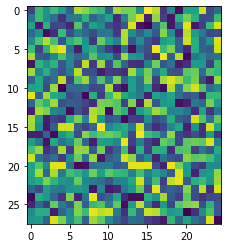

In [4]:
plt.imshow(model.encoder.weights[2].numpy())

In [33]:
def suplement_layers_params(architecture : List[int], layers_params : dict, layers_default_params : dict) -> dict:
    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(architecture) - len(layers_params)):
        layers_params.append({})
    return [{**layers_default_params, **x} for x in layers_params]


widths = [32,28,24,18]
layers_params = [{'l1' : 0.001, 'l2' : 0.0, 'dropout' : 0.2}, {}, {'l1' : 0.01, 'dropout' : 0.2}]
layers_default_params = {'l1' : 0.0, 'l2' : 0.0, 'dropout' : 0.0, 'activation' : "tanh"}
suplement_layers_params(widths, layers_params, layers_default_params)



[{'l1': 0.001, 'l2': 0.0, 'dropout': 0.2, 'activation': 'tanh'},
 {'l1': 0.0, 'l2': 0.0, 'dropout': 0.0, 'activation': 'tanh'},
 {'l1': 0.01, 'l2': 0.0, 'dropout': 0.2, 'activation': 'tanh'},
 {'l1': 0.0, 'l2': 0.0, 'dropout': 0.0, 'activation': 'tanh'}]

In [28]:
{**layers_default_params}

TypeError: 'tuple' object is not a mapping

In [108]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from typing import List, Optional

def suplement_layers_params(architecture : List[int], layers_params : dict, layers_default_params : dict) -> dict:
    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(architecture) - len(layers_params)):
        layers_params.append({})
    return [{**layers_default_params, **x} for x in layers_params]

class DenseTranspose(tf.keras.layers.Layer):
    """
    Dense transpose layer from dense layer
    """
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense 
        self.activation = tf.keras.activations.get(activation)
        super(DenseTranspose, self).__init__(**kwargs)
    def build(self, batch_input_shape):
        self.b = self.add_weight(name= "bias", shape = [ self.dense.input_shape[-1]], initializer = "zeros")
        self.w = self.dense.weights[0]
        super().build(batch_input_shape)
        
        
    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.w, transpose_b = True)
        return self.activation(z + self.b)
    
    def get_weights(self):
        return {"w": np.shape(tf.transpose(self.w))}    
    @property 
    def weights_transpose(self):
        return tf.transpose(self.dense.weights[0])


class Encoder(tf.keras.layers.Layer):
    """
    Encoder

    isFirstInputLayer - use input dimension only in Input Layer
    """
    def __init__(self, 
    widths : List[int] = [32,24], 
    isFirstInputLayer : Optional[bool] = True,
    layers_params : Optional[List[dict]] = [
        {'l1' : 0.001, 'l2' : 0.0, 'dropout' : 0.2}, 
        {},
        {"dropout" : 0.5}
        ],
    layers_default_params : dict = {
        'l1' : 0.0, 
        'l2' : 0.0, 
        'dropout' : 0.0, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.GlorotUniform(),
        'bias_initializer' : tf.keras.initializers.Zeros()
        },
    **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.latent_dim = widths[-1]
        self.input_dim = widths[0]
        self.layers = []
        
        if not ("name" in kwargs.keys()):
            kwargs["name"] = "encoder"

        layers_params = suplement_layers_params(widths, layers_params, layers_default_params)
        
        for (layer_index, layer_dim), layer_params_ in zip(
            enumerate(widths[1:] if isFirstInputLayer else widths), 
            layers_params):

            if layer_params_["dropout"] > 0.0:
                self.layers.append(Dropout(
                    layer_params_["dropout"],
                    name = kwargs["name"] + "_{}_dropout".format(layer_index)
                    ))
            # construct encoder layer 
            self.layers.append(Dense(
                    units = layer_dim,
                    kernel_initializer= layer_params_["kernel_initializer"],
                    bias_initializer= layer_params_["bias_initializer"],
                    kernel_regularizer = tf.keras.regularizers.L1L2(
                        l1=layer_params_["l1"], 
                        l2=layer_params_["l2"]),
                    name = kwargs["name"] + "_{}".format(layer_index)))
        
    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x


    def build_graph(self):
        x = Input(shape=(self.input_dim, ), name = 'encoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))


class Decoder(tf.keras.layers.Layer):
    """
    Decoder

    isTranspose - use transposed layers from encoder. If False create fresh layers of the same size of encoder
    """

    """
    Add decoder documentation.
    """
    def __init__(self, 
    encoder : Encoder, 
    isTranspose : Optional[bool] = True,  
    layers_params : Optional[List[dict]] = [],
    layers_default_params : dict = {
        'l1' : 0.0, 
        'l2' : 0.0,
        'dropout' : 0.0, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.GlorotUniform(),
        'bias_initializer' : tf.keras.initializers.Zeros()
        }, 
    **kwargs):

        super(Decoder, self).__init__(**kwargs)
        self.input_dim = encoder.weights[0].shape[-1]
        self.output_dim = encoder.weights[-1].shape[-1]
        self.layers = []

        if not ("name" in kwargs.keys()):
            kwargs["name"] = "decoder"

        layers_params = suplement_layers_params(widths, layers_params, layers_default_params)

        if isTranspose:
            for layer_index, layer in enumerate([x for x in encoder.layers[1:][::-1] if type(x) == Dense]):
                self.layers.append(
                    DenseTranspose(
                        dense = layer,
                        name = kwargs["name"] + "_{}".format(layer_index)
                        )
                    )
        else:        
            for (layer_index, layer_dim), layer_params_ in zip(
                enumerate([x.input_shape[-1] for x in encoder.layers][1:][::-1]), 
                layers_params):
                
                if layer_params_["dropout"] > 0.0:
                    self.layers.append(Dropout(
                        layer_params_["dropout"],
                        name = kwargs["name"] + "_{}_dropout".format(layer_index)
                        ))

                self.layers.append(Dense(
                    units = layer_dim,
                    kernel_initializer= layer_params_["kernel_initializer"],
                    bias_initializer= layer_params_["bias_initializer"],
                    kernel_regularizer = tf.keras.regularizers.L1L2(
                        l1=layer_params_["l1"], 
                        l2=layer_params_["l2"]),
                    name = kwargs["name"] + "_{}".format(layer_index)))
    
    """
    Add privileged training: training = None 
    """
    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x


    def build_graph(self):
        x = Input(shape=(self.output_dim, ), name = 'decoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))

    """
    Overtide this method to enable serialization 
    """
    def get_config(self):
        pass

class Autoencoder(tf.keras.Model):
    """
    Autoencoder
    Stack both encoder and decoder
    """
    def __init__(self, 
    widths : List[int] = [32,28,25], 
    name : Optional[str] = "autoencoder", 
    ekwargs : Optional[dict] = {}, 
    dkwargs : Optional[dict] = {}, 
    **kwargs):
        if not ("name" in kwargs.keys()):
            kwargs["name"] = "autoencoder"

        super(Autoencoder, self).__init__(**kwargs)
        self.input_dim = widths[0]
        self.latent_dim = widths[-1]
        self.encoder = Encoder(widths, **ekwargs).build_graph()
        self.decoder = Decoder(self.encoder, **dkwargs).build_graph()
    
    def call(self, input):        
        x = self.encoder.layers[1](input)
        for layer in self.encoder.layers[2:] + self.decoder.layers[1:]:
            x = layer(x)
        return x
        
    
    def compile(self, **kwargs):
        super(Autoencoder, self).compile(**kwargs)

    def build_graph(self,):
        x = Input(shape=(self.input_dim, ), name = 'autoencoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))

    def encode(self, input):
        return self.encoder(input)
    
    def decode(self, input):
        return self.decoder(input)

    def get_input_dim(self) -> int:
        return self.input_dim
    
    def get_latent_dim(self) -> int:
        return self.latent_dim

In [111]:
model = Autoencoder([32, 30, 28, 26, 20])
model.build_graph().summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye [(None, 32)]              0         
_________________________________________________________________
encoder_0_dropout (Dropout)  (None, 32)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 30)                990       
_________________________________________________________________
encoder_1 (Dense)            (None, 28)                868       
_________________________________________________________________
encoder_2_dropout (Dropout)  (None, 28)                0         
_________________________________________________________________
encoder_2 (Dense)            (None, 26)                754       
_________________________________________________________________
encoder_3 (Dense)            (None, 20)                540

In [104]:
Encoder([32, 30, 28, 26, 20])

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
decoder_0 (DenseTranspose)   (None, 26)                566       
_________________________________________________________________
decoder_1 (DenseTranspose)   (None, 28)                782       
_________________________________________________________________
decoder_2 (DenseTranspose)   (None, 30)                898       
_________________________________________________________________
decoder_3 (DenseTranspose)   (None, 32)                1022      
Total params: 3,268
Trainable params: 3,268
Non-trainable params: 0
_________________________________________________________________


In [72]:
type(encoder.encoder_layers[1]) == Dropout

False